In [2]:
import numpy as np
import scipy 
from scipy import signal
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
from scipy.io.wavfile import read as wavread
from scipy.signal import find_peaks


In [3]:
path = '/Users/noelalben/Downloads/Fur Elise - Beethoven (Right Hand only) | BEGINNER PIANO TUTORIAL + SHEET MUSIC by Betacustic.wav'

In [4]:
fs, x = wavread(path)
x = x.flatten()
x = x/np.max(x)

## Extracting a small range of x

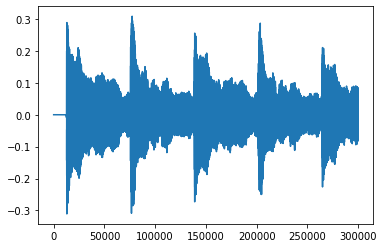

In [5]:
plt.plot(x[380000:680000])
x = x[380000:680000]

## Spectogram

In [6]:
f, t, Zxx = signal.spectrogram(x, fs,'hann', nperseg=1024)


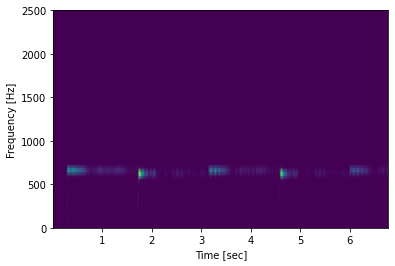

334

In [7]:
plt.pcolormesh(t, f, Zxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2500)
plt.show()
t.size

## Median Filtering

In [9]:
    win_harm =31 #Horizontal
    win_perc = 31 #Vertical
    harm = np.empty_like(Zxx)
    harm[:] = median_filter(Zxx, size=(1,win_harm ), mode='reflect')
    perc = np.empty_like(Zxx)
    perc[:] = median_filter(Zxx, size=(win_perc, 1), mode='reflect')

## Harmonic Content

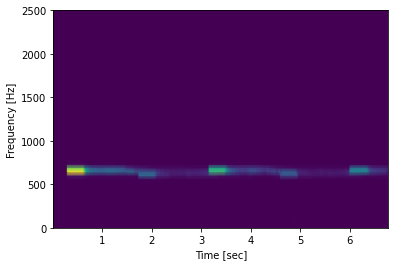

In [10]:
plt.pcolormesh(t, f, harm, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2500)
plt.show()

## Percussive Content

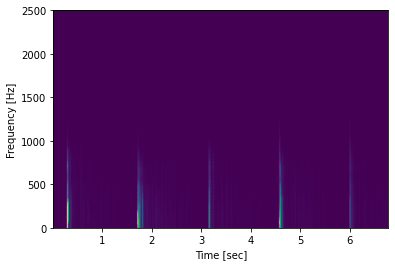

In [11]:
plt.pcolormesh(t, f, perc, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2500)
plt.show()

## Creating a Mask

In [12]:
X = np.greater(harm,perc)
Xy = np.greater(perc,harm)
Mx = np.empty_like(harm)
Mx = np.where(X==True,1,0)
My = np.where(Xy==True,1,0)


In [13]:
Zxx_harm = Mx*Zxx
Zxx_perc = My*Zxx

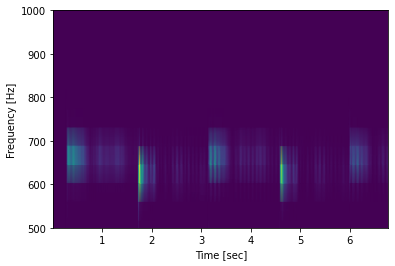

In [14]:


plt.pcolormesh(t, f, Zxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(500, 1000)
plt.show()

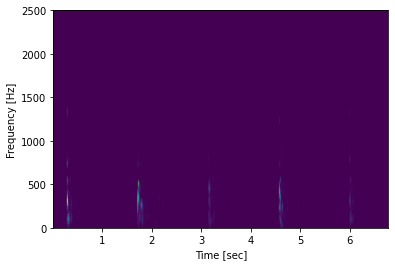

1.759572072072072

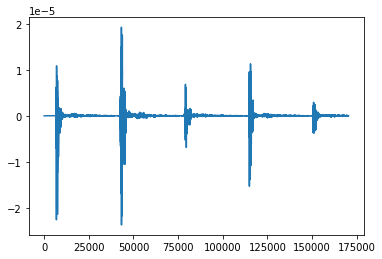

In [15]:
plt.pcolormesh(t, f, Zxx_perc, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2500)
plt.show()
y, xrec = signal.istft(Zxx_perc, fs)
plt.plot(xrec)

In [18]:
xrec.size

170496

In [16]:
scale_factor= x.size/xrec.size

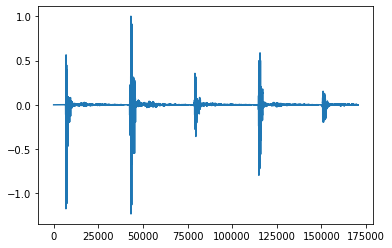

In [17]:
xrec = xrec/max(xrec)
plt.plot(xrec)

## Percussive Content

In [18]:

from scipy.io.wavfile import write
write('perc.wav', 44100,xrec)
import IPython.display as ipd
ipd.Audio('perc.wav')

## Vs the FILE

In [19]:
from scipy.io.wavfile import write
write('AUDIO.wav', 44100,x)
import IPython.display as ipd
ipd.Audio('AUDIO.wav')

## Harmonic Part

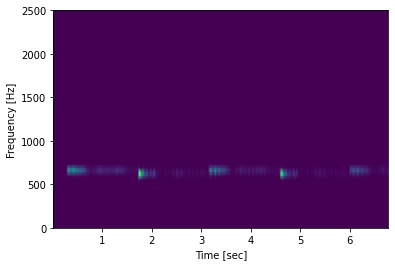

In [20]:
plt.pcolormesh(t, f, Zxx_harm, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 2500)
plt.show()

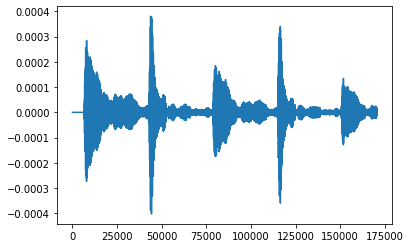

In [25]:
y, xhrm = signal.istft(Zxx_harm, fs)
plt.plot(xhrm)
xhrm = xhrm/max(xhrm)
from scipy.io.wavfile import write
write('AUDIO1.wav', 44100,xhrm)
import IPython.display as ipd
ipd.Audio('AUDIO1.wav')

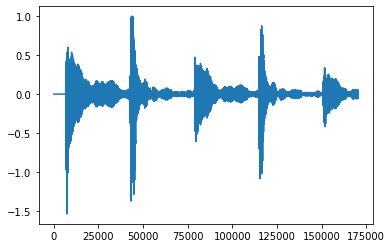

In [30]:
xf = xhrm+xrec
xf = xf/max(xf)
plt.plot(xf)
write('AUDIO2.wav', 44100,xf)
import IPython.display as ipd
ipd.Audio('AUDIO2.wav')

In [31]:
def stp(x, N, H):
    # x:  Input signal
    # N:  Frame length
    # H:  Hopsize
    x_pad = np.concatenate((x, np.zeros(N)))
    num_windows = np.ceil(1 + (len(x) - N) / H)
    win_pos = np.arange(num_windows) * H
    idx = np.array([np.arange(w, w+N) for w in win_pos], dtype='int32')
    P = (x_pad[idx] ** 2).sum(axis=1) / N
    return P

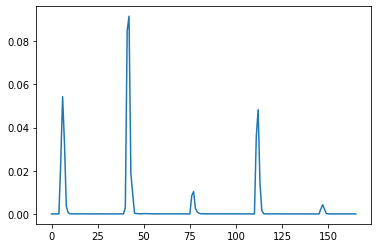

In [32]:
P = stp(xrec,2048,1024)
plt.plot(P)

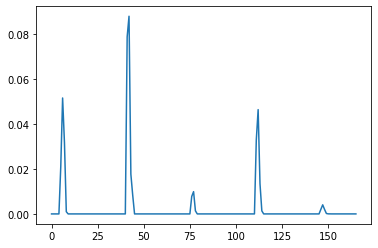

In [33]:
J = 34
Ptm=np.zeros_like(P)
for m in range(P.size):
    Ptm[m] = np.sum(P[m:m+J])/(J+1)
    #print(Ptm[m])

#plt.plot(Ptm)
Pref = P-Ptm
#plt.plot(Pref)
N = np.max((np.zeros_like(P),Pref),axis=0)
plt.plot(N)
#N.size

In [38]:
def peak_picking(N):  
    novelty =N
    pos = np.append(novelty, novelty[-1]) > np.insert(novelty, 0, novelty[0])
    neg = np.logical_not(pos)
    peaks = np.where(np.logical_and(pos[:-1], neg[1:]))[0]
    
    values = novelty[peaks]
    values /= np.max(values)
    peaks = peaks[values >= 0.01]
    values = values[values >= 0.01]
    peaks_idx = np.int32(np.round(peaks*1024*scale_factor))
    return peaks_idx

In [39]:
peaks_idx= peak_picking(N)

In [40]:
peaks_idx

array([ 10811,  75676, 138739, 201802, 264865], dtype=int32)

## Visualize Peaks

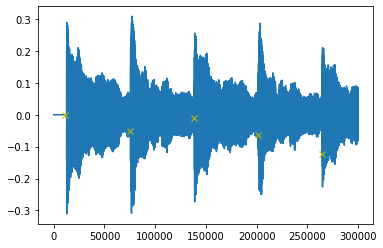

In [41]:
plt.plot(x)
plt.plot(peaks_idx,x[peaks_idx],'x',c='y')

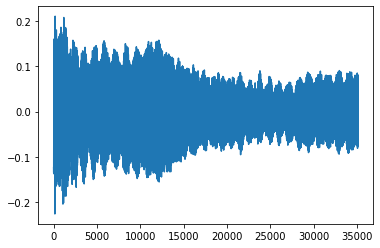

In [45]:
plt.plot(x[peaks_idx[4]:])